<a href="https://colab.research.google.com/github/nikitagrygoriev/CI/blob/master/ProjectCI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wstęp



---



###W tym raporcie zajmujemy się regresją wielomianową (w danym przypadku liniową) na zbiorze "Automobile".  Optymalizowanym parametrem jest średni błąd bezwzględny, do walidacji jest użyta 10-krotna walidacja krzyżowa, a wybranymi hiperparametrami są `Engine_Size` i `Curb_Weight`.



---



#Preprocessing
##Importujemy biblioteki

In [0]:
import pandas as pd
import numpy as np

##Opis danych

In [2]:
with open('imports-85.names', 'r') as f:
  print(f.read())

1. Title: 1985 Auto Imports Database

2. Source Information:
   -- Creator/Donor: Jeffrey C. Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 19 May 1987
   -- Sources:
     1) 1985 Model Import Car and Truck Specifications, 1985 Ward's
        Automotive Yearbook.
     2) Personal Auto Manuals, Insurance Services Office, 160 Water
        Street, New York, NY 10038 
     3) Insurance Collision Report, Insurance Institute for Highway
        Safety, Watergate 600, Washington, DC 20037

3. Past Usage:
   -- Kibler,~D., Aha,~D.~W., \& Albert,~M. (1989).  Instance-based prediction
      of real-valued attributes.  {\it Computational Intelligence}, {\it 5},
      51--57.
	 -- Predicted price of car using all numeric and Boolean attributes
	 -- Method: an instance-based learning (IBL) algorithm derived from a
	    localized k-nearest neighbor algorithm.  Compared with a
	    linear regression prediction...so all instances
	    with missing attribute values were discarded.  This res



---


###Z opisu wynika, że mamy `205` rekórdów i 26 kolumn, z czego tylko 15 są ciągłe (nadają się do regresji). Zbiór zawiera brakujące dane - oznaczone za pomocą '?'.


---



##Podpisywanie kolumn, ponieważ kolumny w zbiorze danych są nienazwane

In [0]:
column_names = ['Symboling','Normalized_Losses','Make','Fuel_Type','Aspiration',
                'Num_Of_Doors','Body_Style','Drive_Wheels','Engine_Location',
                'Wheel_Base','Length','Width','Height','Curb_Weight','Engine_Type',
                'Num_Of_Cylinders','Engine_Size','Fuel_System','Bore','Stroke',
                'Compression_Ratio','Horsepower','Peak_RPM','City_MPG','Highway_MPG',
                'Price']

##Wczytywanie danych do zmiennnej `df` i sprawdzanie poprawności

In [4]:
df = pd.read_csv('imports-85.data', names=column_names, header=None)
df.head()

,Symboling,Normalized_Losses,Make,Fuel_Type,Aspiration,Num_Of_Doors,Body_Style,Drive_Wheels,Engine_Location,Wheel_Base,Length,Width,Height,Curb_Weight,Engine_Type,Num_Of_Cylinders,Engine_Size,Fuel_System,Bore,Stroke,Compression_Ratio,Horsepower,Peak_RPM,City_MPG,Highway_MPG,Price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


##Sprawdzaanie czy ilość rekordów zgadza się z podaną w opisie




In [5]:
len(df)

205

##Usuwanie rekordów w których brakuje danych

In [6]:
for col in column_names:
 df = df[df[col] != '?']

len(df) 

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


159



---


### Po usunięciu rekordów z brakującymi danymi, pozostaje nam 159 rekordów do użycia.

---



##Sprawdzanie zależności ceny od innych zmiennych

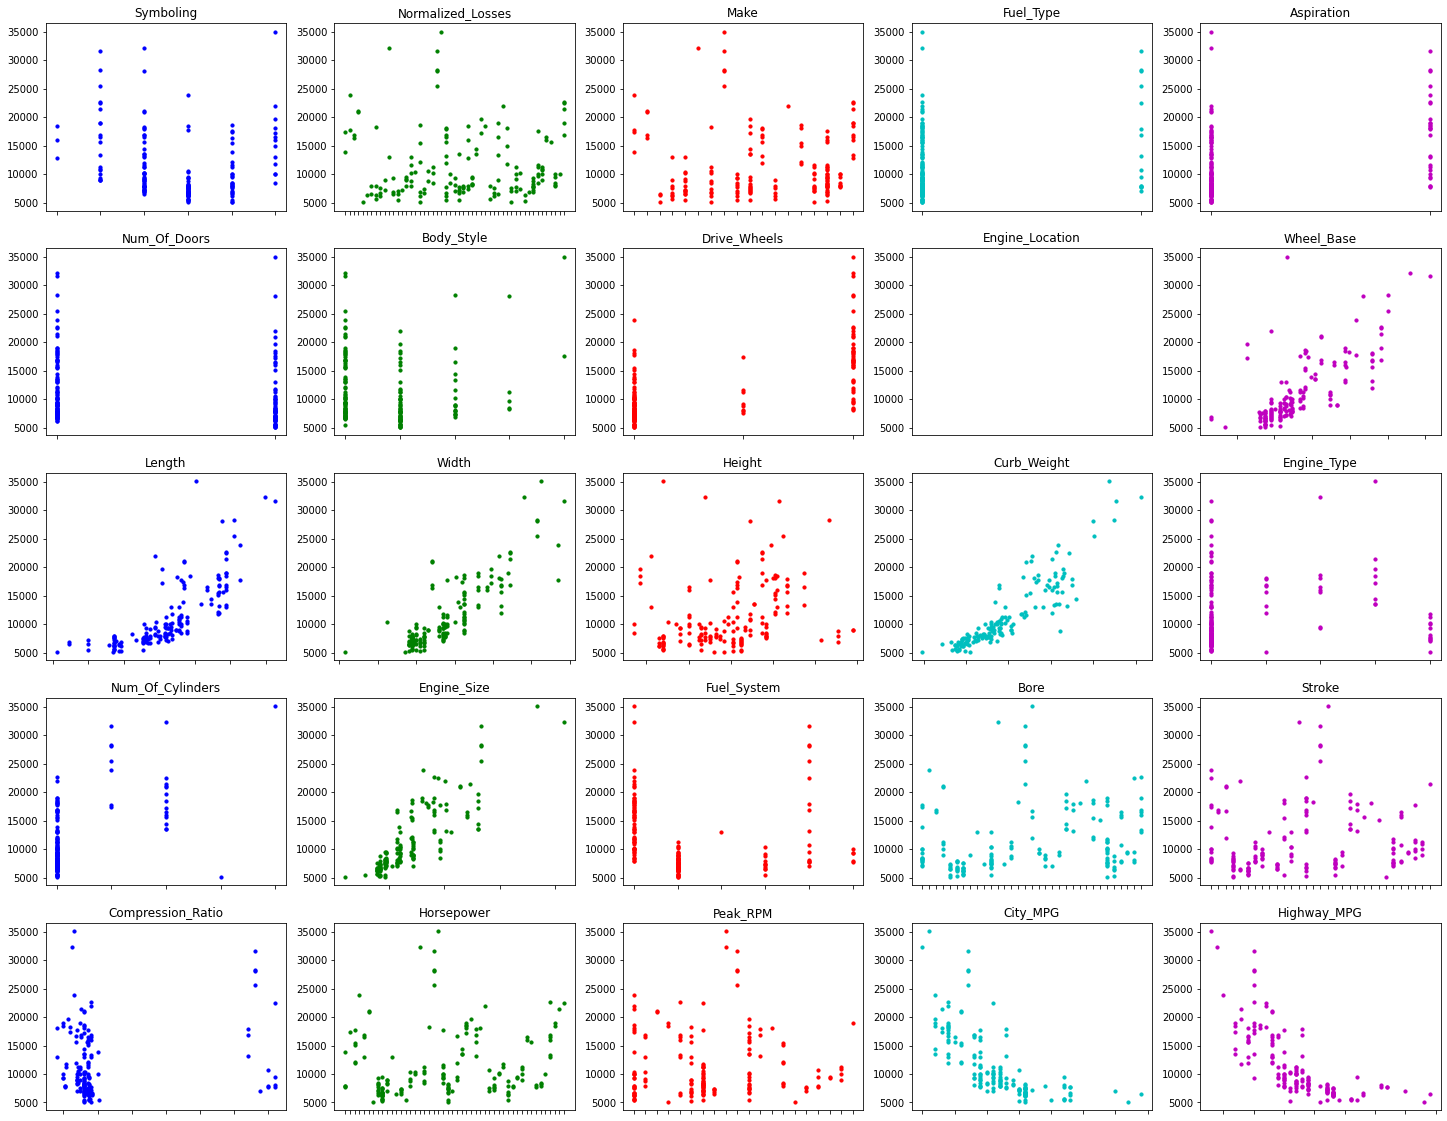

In [7]:
from matplotlib import pyplot as plt 
from matplotlib.pyplot import figure
from itertools import cycle

cycol = cycle('bgrcm')

target = ['Price'] 

def plotParams(df, parameters, ys):
  figure(figsize=(25, 20))  
  for (i, param) in enumerate(parameters):
    ax = plt.subplot(5, 5, i + 1)
    ax.title.set_text(param)
    ax.set_xticklabels([])
    plt.scatter(df[param].values.tolist(), df[ys].values.tolist(), s=10, c=next(cycol))

plotParams(df, column_names[:-1], target)

### Z wykresów widzimy, że tylko kolumny `'Normalized_Losses', 'Wheel_Base', 'Length', 'Width', 'Height', 'Curb_Weight', 'Engine_Size', 'Bore', 'Stroke', 'Compression_Ratio', 'Horsepower', 'Peak_RPM', 'City_MPG', 'Highway_MPG', 'Price'` maja ciągłe dane, więc tylko te kolumny zostaną wykorzystane do regresji.

##Usuwanie kolumn z nieciągłymi danymi

159

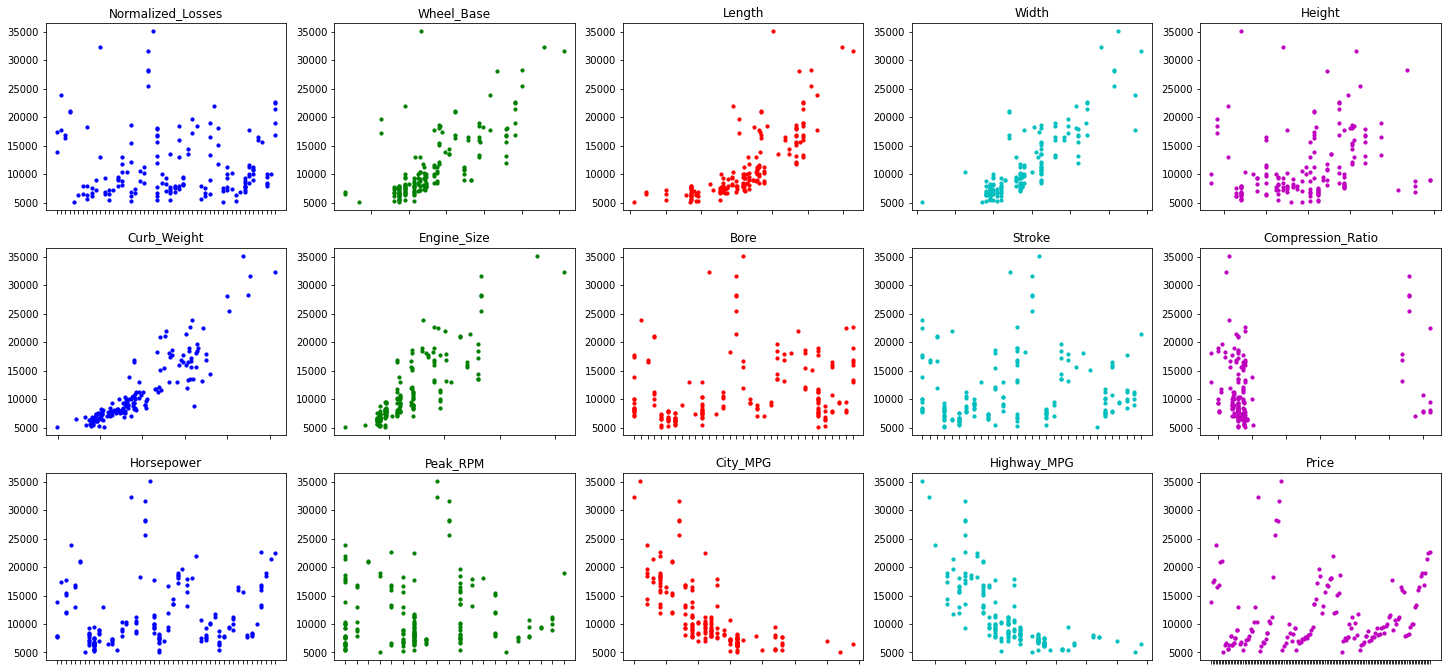

In [8]:
df_continuous = ['Normalized_Losses','Wheel_Base','Length','Width','Height',
              'Curb_Weight','Engine_Size','Bore','Stroke','Compression_Ratio',
              'Horsepower','Peak_RPM','City_MPG','Highway_MPG','Price']

df_clean = pd.DataFrame(columns=df_continuous)
df_clean[df_continuous] = df[df_continuous]
plotParams(df_clean, df_continuous, target)
len(df_clean)



---


###Z wykresów wynika, że najbardziej sensownymi danymi do regresji są:

###`Wheel_Base`, `Length`, `Width`, `Curb_Weight`, `Engine_Size`, `City_MPG` i `Highway_MPG`


---

##Normalizacja

In [0]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_clean)
df_normalized = pd.DataFrame(x_scaled)
df_normalized.columns = df_continuous

#Regresja

##Funkcja do robienia regresji

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


def train(dataframe, parameters, target):
  
  X = pd.DataFrame(columns=parameters)
  y = pd.DataFrame(columns=target)      
  
  for col in parameters:
    X[col] = dataframe[col]
  for col in target:
    y[col] = dataframe[col]
  
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3)
  
  reg = LinearRegression()
  reg.fit(x_train, y_train)
  y_pred = reg.predict(x_test)

  x_test = [float(i) for i in x_test[parameters[0]].values]
  y_test = [float(i) for i in y_test['Price'].values]
  y_pred = [i[0] for i in y_pred]

  # print(y_pred)
  # print(y_test)
  # print(x_test)
  return y_pred, y_test, x_test

##Funkcja obliczająca błąd

In [0]:
def score(y_pred, y_test):
  y_pred_norm = np.asarray([float(i) / max(y_pred) for i in y_pred])
  y_test_norm = np.asarray([float(i) / max(y_test) for i in y_test])
  return np.mean(abs((y_pred_norm - y_test_norm)))

##Wykres wyników regresji w zależności od hiperparametrów

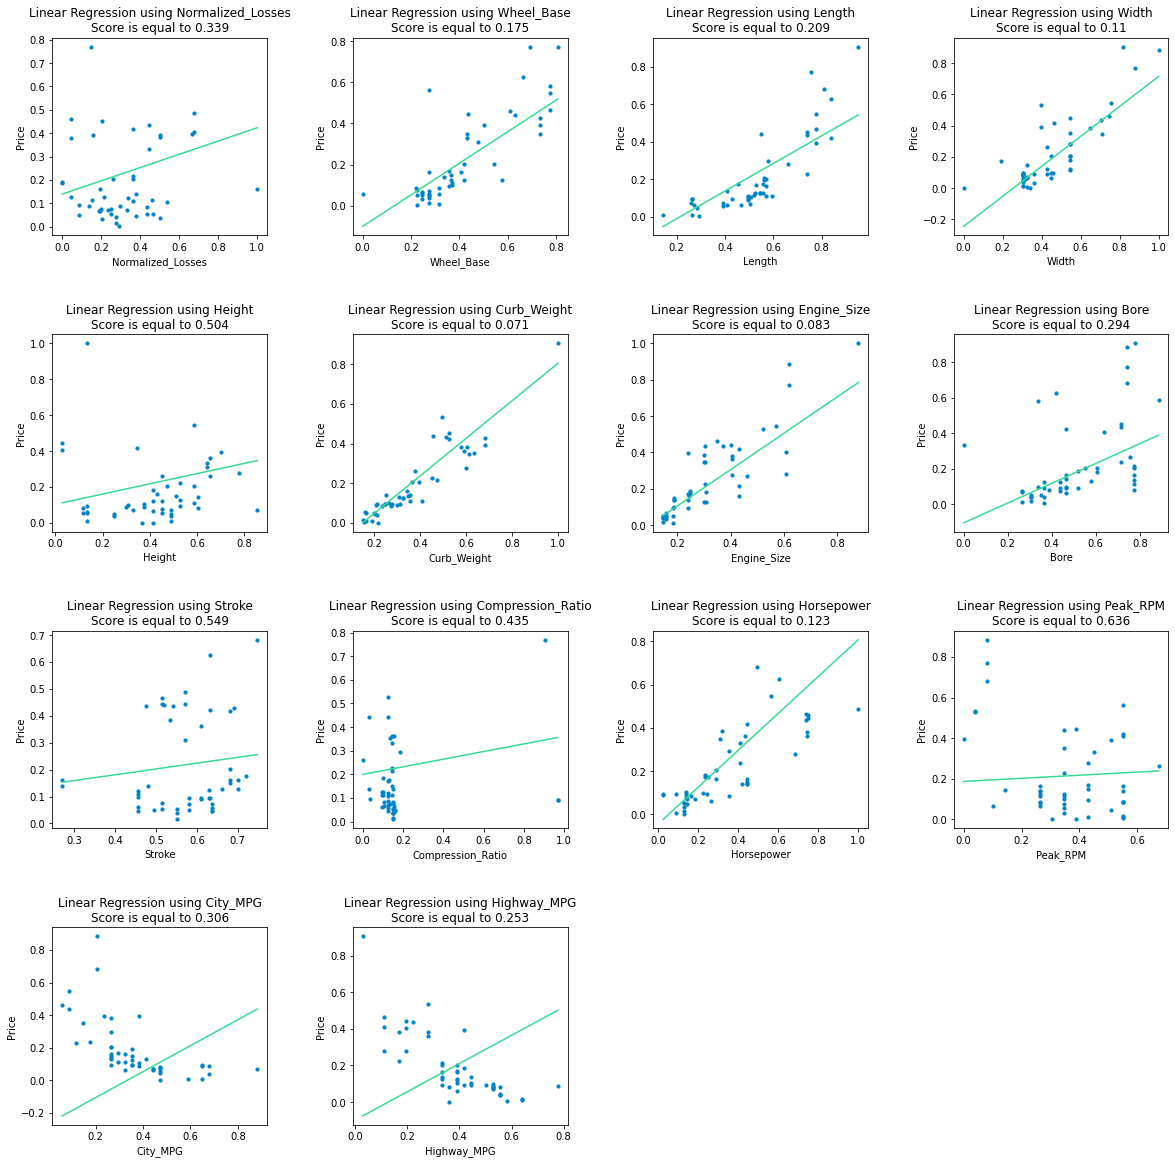

In [12]:
def plotRes(xs, ys, parameter, i, score):
  plt.subplot(4, 4, i)
  plt.title(f'Linear Regression using {parameter}\nScore is equal to {round(score.pop(),3)}')
  plt.xlabel(parameter)
  plt.ylabel('Price')
  plt.plot([min(xs),max(xs)], [min(ys[0]),max(ys[0])],color='#35db92')  
  #plt.plot(xs,ys[0],color='#35db92')  
  plt.scatter(xs, ys[1], color='#0084c7', s=10)   
  

fig = figure(figsize=(20, 20))
plt.subplots_adjust(wspace=.4, hspace=.5)

for i in range(len(df_continuous)-1):
  pred, test, axis = train(df_normalized, [df_continuous[i]], ['Price'])
  plotRes(axis, [pred,test], df_continuous[i], i + 1, {score(pred, test)})

plt.show()  



---


### Na pierwszy rzut oka wydaje się, że hiperparametry `Engine_Size` i `Curb_Weight` są optymalnymi parametrami, ale musimy się upewnić poprzez przeprowadzenie walidacji krzyżowej.

---



#Walidacja krzyżowa

In [13]:
from sklearn.model_selection import KFold


def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return score(y_pred, y_test.values)


for ind in range(len(df_continuous)-2):
  scores = []
  X_set = df_normalized[df_continuous[ind]]
  y_set = df_normalized['Price']
  kf = KFold(n_splits=10)
  for train_index, test_index in kf.split(X_set, y_set):
      X_train, X_test, y_train, y_test = X_set.loc[train_index], X_set.loc[test_index], y_set.loc[train_index], y_set.loc[test_index]
      scores.append(get_score(LinearRegression(), X_train.values.reshape(-1, 1), X_test.values.reshape(-1, 1), y_train, y_test))  
  print(df_continuous[ind], "score:", round(sum(scores) / len(scores), 2))
  print("-"*35,"\n")    

Normalized_Losses score: 0.43
----------------------------------- 

Wheel_Base score: 0.25
----------------------------------- 

Length score: 0.24
----------------------------------- 

Width score: 0.18
----------------------------------- 

Height score: 0.41
----------------------------------- 

Curb_Weight score: 0.14
----------------------------------- 

Engine_Size score: 0.17
----------------------------------- 

Bore score: 0.28
----------------------------------- 

Stroke score: 0.48
----------------------------------- 

Compression_Ratio score: 0.43
----------------------------------- 

Horsepower score: 0.16
----------------------------------- 

Peak_RPM score: 0.44
----------------------------------- 

City_MPG score: 0.22
----------------------------------- 





---


###Walidacja krzyżowa potwiedza wybór `Engine_Size`i `Curb_Weight` jako hiperparametrów.

---



#Krzywa uczenia dla hiperametru `Engine_Size`

[-0.          0.05125695  0.0680952   0.05894799  0.05747943  0.0608829
  0.06153845  0.05933689  0.06297463  0.06073268  0.06205275  0.0597237
  0.05815153]


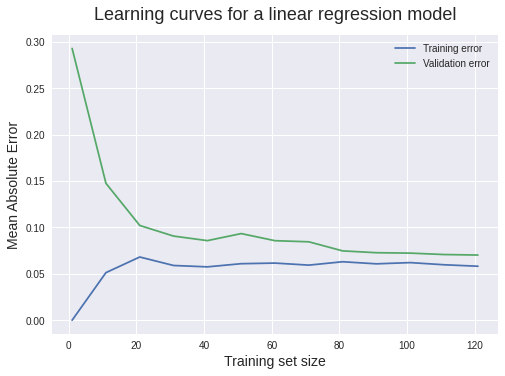

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

def find_curve(estimator, X, y):
  train_sizes = range(1, 127, 10)
  train_sizes, train_scores, validation_scores = learning_curve(estimator=estimator, X=X, y=y, 
                          train_sizes = train_sizes, cv = 5, scoring = 'neg_mean_absolute_error')
  
  train_scores_mean = -train_scores.mean(axis = 1)
  validation_scores_mean = -validation_scores.mean(axis = 1)
  return train_sizes, train_scores_mean, validation_scores_mean


def plot_curve(train_sizes, train_scores_mean, validation_scores_mean):
  plt.style.use('seaborn')
  plt.plot(train_sizes, train_scores_mean, label='Training error')
  plt.plot(train_sizes, validation_scores_mean, label='Validation error')
  plt.ylabel('Mean Absolute Error', fontsize=14)
  plt.xlabel('Training set size', fontsize=14)
  plt.title('Learning curves for a linear regression model', fontsize=18, y=1.03)
  plt.legend()


X_set = df_normalized[df_continuous[5:7]].values
y_set = df_normalized[target]
train_size, train_score_mean, validation_score_mean = find_curve(LinearRegression(), X_set, y_set)
plot_curve(train_size, train_score_mean, validation_score_mean)

#Podsumowanie



---


###Po przeprowadzeniu regresji, walidacji krzyżowej i narysowaniu krzywej uczenia wnioskujemy, że optymalnymi hiperparametrami do regresji są `Engine_Size` i `Curb_Weight`, a rozmiar zbioru treningowego - około 100, ponieważ dalsze zwiększanie zbioru treningowego nie zwiększa skuteczności.
###Dla naszego modelu średni błąd bezwzględny wynosi około 0.05 - 0.06.



---

